In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import *
from models.vl_encoders import VLE_REGISTRY, MapComputeMode, VLEncoder
from data import VOC2012SegDataset, get_many_answer_gt, get_many_answer_pr, flatten_class_splitted_answers
from color_map import apply_colormap
from viz import overlay_map, display_token_length_distr, write_html_multi_row_image_caption, display_prompt
from path import get_mask_prs_path
from utils import flatten_list, blend_tensors, flatten_list_to_depth
from prompter import get_significant_classes
from viz import create_diff_mask

import torch
import torchvision.transforms.v2.functional as TF
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image
from pathlib import Path
from itertools import product

from typing import Optional, Literal

In [3]:
# TODO use Git SubModules to integrate external repos in the project

# Attention Maps

In [4]:
# model: VLEncoder = VLE_REGISTRY.get('flair', checkpoint='flair-cc3m-recap.pt')
model: VLEncoder = VLE_REGISTRY.get("flair", version='flair-cc3m-recap.pt', device=CONFIG['device'], vision_adapter=True)
# model: VLEncoder = VLE_REGISTRY.get('fg-clip', checkpoint='fg-clip-large')

checkpoint_dict = torch.load(Path('/home/olivieri/exp/data/torch_weights/vle/flair/flair-flair-cc3m-recap.pt-adapter_RB_250724_0738.pth'))
model.model.load_state_dict(checkpoint_dict['model_state_dict']) # load my weights

<All keys matched successfully>

In [5]:
img_idxs = [9, 10, 11, 12, 13, 14, 15, 17]

map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST
normalize = True
mask_alpha = 0.55 # the greater, the less scene is visible 
map_alpha = 1.0
viz_image_size = 350

In [6]:
def compute_maps_with_captions(
        model: VLEncoder,
        images: torch.Tensor,
        captions: list[str],
        map_compute_mode: MapComputeMode,
        viz_image_size: Optional[int | list[int]] = None,
        map_resize_mode: TF.InterpolationMode = TF.InterpolationMode.NEAREST,
        normalize: bool = True,
) -> list[tuple[Image.Image, str]]:
    image_text_list = []

    for img, text in zip(images, captions):
        img_tensor = model.preprocess_images([img], device=CONFIG['device'])
        text_tensor = model.preprocess_texts([text], device=CONFIG['device'])
        sim = model.get_similarity(img_tensor, text_tensor, broadcast=False)
        map, min_value, max_value = model.get_maps(
            img_tensor, text_tensor,
            map_compute_mode=map_compute_mode,
            upsample_size=viz_image_size, upsample_mode=map_resize_mode,
            attn_heads_idx=[0, 3, 5, 7] # as done by the authors
        ) # [1, H, W], m, M
        map = map.squeeze(0) # [1, H, W]
        if viz_image_size:
            img = TF.resize(img, size=viz_image_size, interpolation=TF.InterpolationMode.BILINEAR)
        ovr_img = overlay_map(img, map, normalize=normalize, alpha=map_alpha) # (H_viz, W_viz)

        image_text_list.append((ovr_img, f"SIM = {sim.item():.2f}", f"MIN VALUE = {min_value.item():.2f}, MAX VALUE = {max_value.item():.2f}", text, "---"))

    return image_text_list

## Non-splitted

In [7]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False, format_to_dict=True)
answers_gt_text = [answers_gt[i] for i in img_idxs]
len(answers_gt_text)

8

### Predictions Masks

In [8]:
def compute_pr_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        contrastive: bool,
) -> list[str | Image.Image]:
    answers_gt = get_many_answer_gt(by_model, return_state=False, format_to_dict=True)
    answers_gt_text = [answers_gt[i] for i in img_idxs]
    viz_ds = VOC2012SegDataset(
        root_path=Path(CONFIG['datasets']['VOC2012_root_path']),
        split='prompts_split',
        resize_size=CONFIG['seg']['image_size'], # then downsampled
        center_crop=True,
        img_idxs=img_idxs,
        mask_prs_path=get_mask_prs_path(by_model=by_model)
    )
    scs, gts, prs = viz_ds[:]
    mask_prs = apply_colormap(prs, viz_ds.get_color_map_dict()).squeeze(0)
    ovr_mask_prs = [blend_tensors(sc, pr, alpha) for pr, sc in zip(mask_prs, scs)]
    if contrastive:
        ovr_mask_prs = [ovr_mask_prs[0]]*int(len(ovr_mask_prs)/2) + [ovr_mask_prs[4]]*int(len(ovr_mask_prs)/2)
    pr_image_text_list = compute_maps_with_captions(vle, ovr_mask_prs, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
    return pr_image_text_list

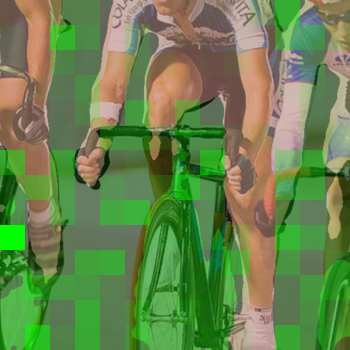

SIM = 0.19

MIN VALUE = 0.00, MAX VALUE = 0.03

The prediction masks for the ground truth PERSON and BIKE regions are overall coarser and more irregular. The body and the handles of the BIKE regions are in general severely under-segmented, while the PERSON regions are segmented in an erratic, inconsistent way.


---

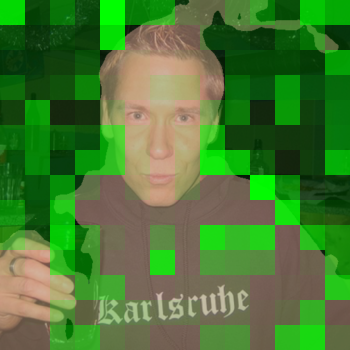

SIM = 0.19

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask for the ground truth PERSON region is imperfect, some area has been missed on the bottom-left while some area has been hallucinated on the top edge. Of all the ground truth BOTTLE instances (two on the left half and two on the right half of the scene) have been completely missed by the prediction.


---

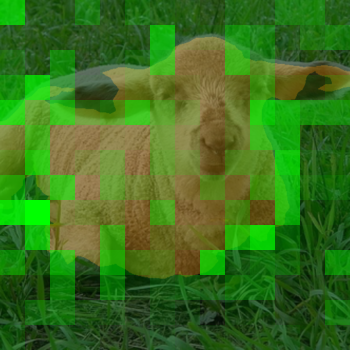

SIM = 0.21

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction mask for the ground truth SHEEP region is incomplete in the top-right corner and in the top-left corner. Moreover, The boundaries are imperfect towards the center-bottom and there is some slight over-extension on the center-bottom-right.


---

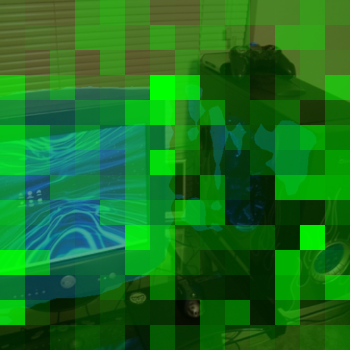

SIM = 0.17

MIN VALUE = 0.00, MAX VALUE = 0.02

The prediction hallucinated several TVMONITOR patches on the right half of the scene.


---

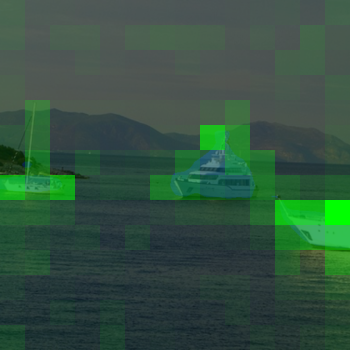

SIM = 0.21

MIN VALUE = 0.00, MAX VALUE = 0.05

The ground truth BOAT region on the left has a more blob-like and over-extended shape and its mast has mostly been missed.


---

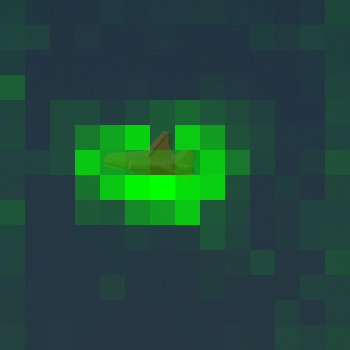

SIM = 0.24

MIN VALUE = 0.00, MAX VALUE = 0.05

The prediction mask for the ground truth AEROPLANE region has some slightly coarser boundaries.


---

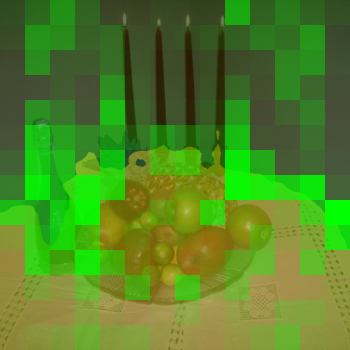

SIM = 0.18

MIN VALUE = 0.00, MAX VALUE = 0.02

The ground truth DININGTABLE has been segmented with some irregular, erratic and over-extended boundaries in the center of the scene, and the prediction mask for the ground truth BOTTLE region is under-segmented a bit.


---

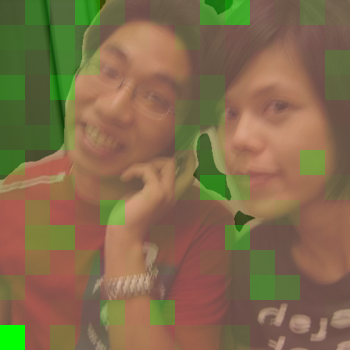

SIM = 0.15

MIN VALUE = 0.00, MAX VALUE = 0.06

The boundaries of the prediction mask for the ground truth PERSON region tend to be coarser and over-extended.


---

In [9]:
pr_image_text_list = compute_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=False
)
display_prompt(flatten_list(pr_image_text_list))

####  Contrastive analysis

In [10]:
con_pr_image_text_list = compute_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=True
)
# display_prompt(flatten_list(con_pr_image_text_list))

### Ground truth masks:

In [11]:
def compute_gt_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        contrastive: bool,
) -> list[str | Image.Image]:
    answers_gt = get_many_answer_gt(by_model, return_state=False, format_to_dict=True)
    answers_gt_text = [answers_gt[i] for i in img_idxs]
    viz_ds = VOC2012SegDataset(
        root_path=Path(CONFIG['datasets']['VOC2012_root_path']),
        split='prompts_split',
        resize_size=CONFIG['seg']['image_size'], # then downsampled
        center_crop=True,
        img_idxs=img_idxs,
        mask_prs_path=get_mask_prs_path(by_model=by_model)
    )
    scs, gts, prs = viz_ds[:]
    mask_gts = apply_colormap(gts, viz_ds.get_color_map_dict()).squeeze(0)
    ovr_mask_gts = [blend_tensors(sc, gt, alpha) for gt, sc in zip(mask_gts, scs)]
    if contrastive:
        ovr_mask_gts = [ovr_mask_gts[0]]*int(len(ovr_mask_gts)/2) + [ovr_mask_gts[4]]*int(len(ovr_mask_gts)/2)
    gt_image_text_list = compute_maps_with_captions(vle, ovr_mask_gts, answers_gt_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize)
    return gt_image_text_list

In [12]:
gt_image_text_list = compute_gt_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
    contrastive=False
)
# display_prompt(flatten_list(gt_image_text_list))

In [13]:
pr_images_row = [el[0] for el in pr_image_text_list]
gt_images_row = [el[0] for el in gt_image_text_list]
captions = answers_gt_text

In [14]:
rows = {"PR masks": pr_images_row, "GT masks": gt_images_row}
write_html_multi_row_image_caption(rows, captions)

Successfully created index.html. Open it in your browser to see the result.


In [15]:
write_html_multi_row_image_caption(rows, captions)

Successfully created index.html. Open it in your browser to see the result.


## Class-splitted

### Prediction Masks

In [7]:
def compute_cs_pr_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
) -> list[str | Image.Image]:
    prs_path = Path('/home/olivieri/exp/data/prompts_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl')
    cs_answers_pr = get_many_answer_pr(prs_path, return_state=False, format_to_dict=True)
    cs_answers_pr_text = [list(cs_answers_pr[i].values()) for i in img_idxs]
    viz_ds = VOC2012SegDataset(
        root_path=Path(CONFIG['datasets']['VOC2012_root_path']),
        split='prompts_split',
        resize_size=CONFIG['seg']['image_size'], # then downsampled
        center_crop=True,
        img_idxs=img_idxs,
        mask_prs_path=get_mask_prs_path(by_model=by_model)
    )
    scs, gts, prs = viz_ds[:]
    significant_classes_pr = get_significant_classes(prs, batched=True)
    [sign_classes.remove(0) for sign_classes in significant_classes_pr]
    cs_color_map_dicts = [list({c: [255, 255, 255] if c == pos_class else [0, 0, 0] for c in range(viz_ds.get_num_classes())} for pos_class in classes if pos_class != 0) for classes in significant_classes_pr]
    cs_mask_prs = [list(apply_colormap([prs[i]], cs_color_map_dicts[i][t]).squeeze(0) for t, pos_class in enumerate(classes)) for i, classes in enumerate(significant_classes_pr)]
    cs_ovr_mask_prs = [list(blend_tensors(sc, pr, alpha) for pr in cs_prs) for cs_prs, sc in zip(cs_mask_prs, scs)]
    cs_pr_image_text_list = [compute_maps_with_captions(vle, ovr_mask_prs, answers_pr_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize) for ovr_mask_prs, answers_pr_text in zip(cs_ovr_mask_prs, cs_answers_pr_text)]
    return cs_pr_image_text_list

In [9]:
cs_pr_image_text_list = compute_cs_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
)
# display_prompt(flatten_list(cs_pr_image_text_list))

### Diff. Masks

In [7]:
def compute_cs_pr_maps_with_captions(
        by_model: str,
        img_idxs: list[int],
        vle: VLEncoder,
        mask_color: Literal['L', 'RB'],
        alpha: float,
        map_compute_mode: MapComputeMode,
        map_resize_mode: TF.InterpolationMode,
        viz_image_size: int | tuple[int, int],
        normalize: bool,
        contrastive: bool = False
) -> list[str | Image.Image]:
    prs_path = Path('/home/olivieri/exp/data/prompts_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl')
    cs_answers_pr = get_many_answer_pr(prs_path, return_state=False, format_to_dict=True)
    cs_answers_pr_text = [list(cs_answers_pr[i].values()) for i in img_idxs]
    viz_ds = VOC2012SegDataset(
        root_path=Path(CONFIG['datasets']['VOC2012_root_path']),
        split='prompts_split',
        resize_size=CONFIG['seg']['image_size'], # then downsampled for viz
        center_crop=True,
        img_idxs=img_idxs,
        mask_prs_path=get_mask_prs_path(by_model=by_model)
    )
    
    scs, gts, prs = viz_ds[:]

    cs_ovr_mask_prs = []

    for sc, gt, pr in zip(scs, gts, prs):
        gt_sign_classes = get_significant_classes(gt)
        pr_sign_classes = get_significant_classes(pr)
        sign_classes = list(set(gt_sign_classes + pr_sign_classes))
        if 0 in sign_classes and sign_classes != [0]:
            sign_classes.remove(0)
        sign_classes = sorted(sign_classes)

        ovr_mask_prs = []

        for pos_c in sign_classes:
            pos_class_gt = (gt == pos_c)
            pos_class_pr = (pr == pos_c)

            diff_mask = create_diff_mask(pos_class_gt, pos_class_pr)

            # L overlay image
            ovr_diff_mask_L = blend_tensors(sc, diff_mask*255, alpha)

            # RB overlay image
            diff_mask += (diff_mask*pos_class_gt) # sets to 2 the false negatives
            diff_mask_col_RB = apply_colormap([diff_mask], {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 0, 255)}).squeeze()
            ovr_diff_mask_RB = blend_tensors(sc, diff_mask_col_RB, alpha)

            if mask_color == 'L':
                ovr_mask_prs.append(ovr_diff_mask_L)
            elif mask_color == 'RB':
                ovr_mask_prs.append(ovr_diff_mask_RB)

        if contrastive:
            ovr_mask_prs = [ovr_mask_prs[0]]*int(len(ovr_mask_prs)) # instead of show consider positive images, show only the first one.

        cs_ovr_mask_prs.append(ovr_mask_prs)
    
    cs_pr_image_text_list = [compute_maps_with_captions(vle, ovr_mask_prs, answers_pr_text, map_compute_mode=map_compute_mode, viz_image_size=viz_image_size, map_resize_mode=map_resize_mode, normalize=normalize) for ovr_mask_prs, answers_pr_text in zip(cs_ovr_mask_prs, cs_answers_pr_text)]
    
    return cs_pr_image_text_list

#### RB

In [11]:
cs_pr_image_text_list = compute_cs_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    mask_color='RB',
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
)
# display_prompt(flatten_list(cs_pr_image_text_list))

##### Contrastive Analysis

In [ ]:
...

#### L

In [ ]:
cs_pr_image_text_list = compute_cs_pr_maps_with_captions(
    by_model="LRASPP_MobileNet_V3",
    img_idxs=img_idxs,
    vle=model,
    mask_color='L',
    alpha=mask_alpha,
    map_compute_mode=map_compute_mode,
    map_resize_mode=map_resize_mode,
    viz_image_size=viz_image_size,
    normalize=normalize,
)
display_prompt(flatten_list(cs_pr_image_text_list))

---
#### HTML Viz

In [27]:
title = 'cc3m-recap, v-adapter'
rows = dict()
checkpoint_path = '/home/olivieri/exp/data/torch_weights/vle/flair/flair-flair-cc3m-recap.pt-v-adapter_L_250725_0627.pth'

sim_datas = []

for mask_a, contr in product(mask_alphas:=[mask_alpha, 0.0], contrs:=[False, True]):
    # model: VLEncoder = VLE_REGISTRY.get('flair', checkpoint='flair-cc3m-recap.pt')
    model: VLEncoder = VLE_REGISTRY.get("flair", version='flair-cc3m-recap.pt', device=CONFIG['device'], vision_adapter=True, text_adapter=False)
    # model: VLEncoder = VLE_REGISTRY.get('fg-clip', checkpoint='fg-clip-large')

    checkpoint_dict = torch.load(Path(checkpoint_path))
    model.model.load_state_dict(checkpoint_dict['model_state_dict']) # load my weights

    cs_pr_image_text_list = compute_cs_pr_maps_with_captions(
        by_model="LRASPP_MobileNet_V3",
        img_idxs=img_idxs,
        vle=model,
        mask_color='L',
        alpha=mask_a,
        map_compute_mode=map_compute_mode,
        map_resize_mode=map_resize_mode,
        viz_image_size=viz_image_size,
        normalize=normalize,
        contrastive=contr
    )
    # display_prompt(flatten_list(cs_pr_image_text_list))

    if sim_datas == []:
        sim_datas = ["" for _ in range(len(flatten_list_to_depth(cs_pr_image_text_list, depth=1)))]

    new_sim_data = [f"{el[1]}<br>{el[2]}<br>" for el in flatten_list_to_depth(cs_pr_image_text_list, depth=1)]
    sim_datas = [s_d+new_s_d for s_d, new_s_d in zip(sim_datas, new_sim_data)]

    del model

    images_row = [el[0] for el in flatten_list_to_depth(cs_pr_image_text_list, depth=1)]

    rows |= {f"{contr=}, {mask_a=}": images_row}

In [28]:
captions = [s_d+f"<br>{el[3]}" for s_d, el in zip(sim_datas, flatten_list_to_depth(cs_pr_image_text_list, depth=1))]

In [29]:
write_html_multi_row_image_caption(title, rows, captions)

Successfully created index.html. Open it in your browser to see the result.


# Token Length Analysis

**Ground truths** (non-splitted):

In [76]:
answers_gt = get_many_answer_gt("LRASPP_MobileNet_V3", return_state=False)
captions = [a['content'] for a in answers_gt]
tok_lengths = [model.count_tokens(t) for t in captions]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

80

critical_answers_amount=4


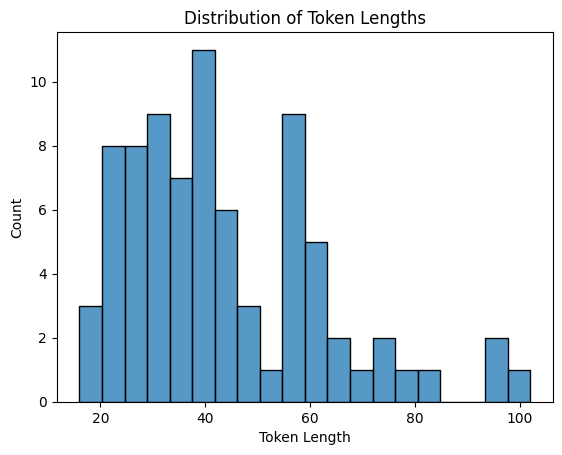

In [77]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Class-splitted predictions**:

In [78]:
prs_path = Path('/home/olivieri/exp/data/prompts_data/by_model/LRASPP_MobileNet_V3/class-splitted/answer_prs/gemma3:12b-it-qat/speed_test/SepMasks_Ovr_1fs.jsonl')
answers_pr = flatten_class_splitted_answers(get_many_answer_pr(prs_path, return_state=False))
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

144

critical_answers_amount=2


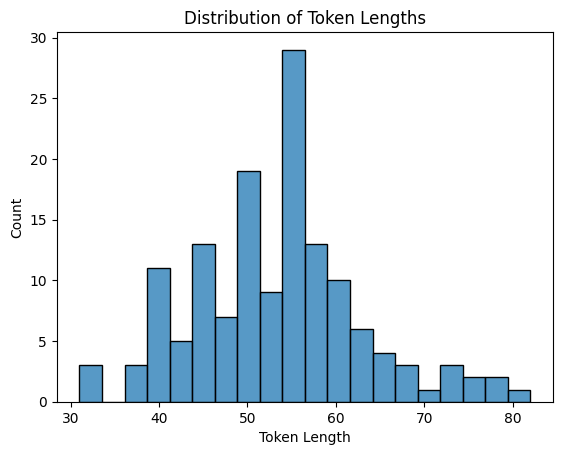

In [79]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

**Non-splitted predictions**:

In [80]:
prs_path = Path('/home/olivieri/exp/data/prompts_data/by_model/LRASPP_MobileNet_V3/non-splitted/answer_prs/gemini-2.0-flash/baseline/SepMasks_Ovr.jsonl')
answers_pr = get_many_answer_pr(prs_path, return_state=False)
answers_pr_text = [a['content'] for a in answers_pr]
tok_lengths = [model.count_tokens(t) for t in answers_pr_text]
critical_answers_amount = len([tl for tl in tok_lengths if tl > model.context_length])
len(tok_lengths)

77

critical_answers_amount=3


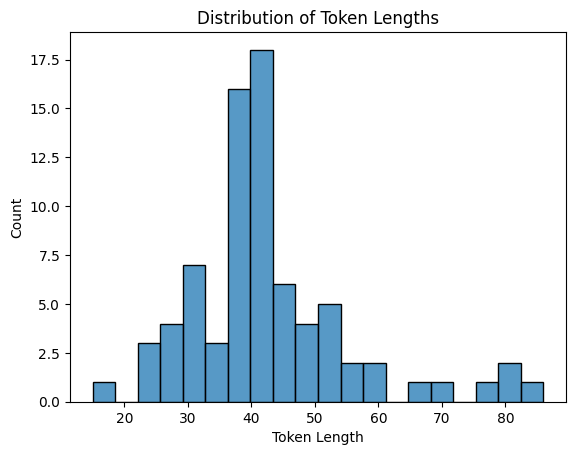

In [81]:
print(f"{critical_answers_amount=}")
display_token_length_distr(tok_lengths)

# Demo

In [82]:
model: VLEncoder = VLE_REGISTRY.get('flair')
# model: VLEncoder = VLE_REGISTRY.get('fg-clip')

In [83]:
map_compute_mode = MapComputeMode.ATTENTION
map_resize_mode = TF.InterpolationMode.NEAREST

(453, 604)


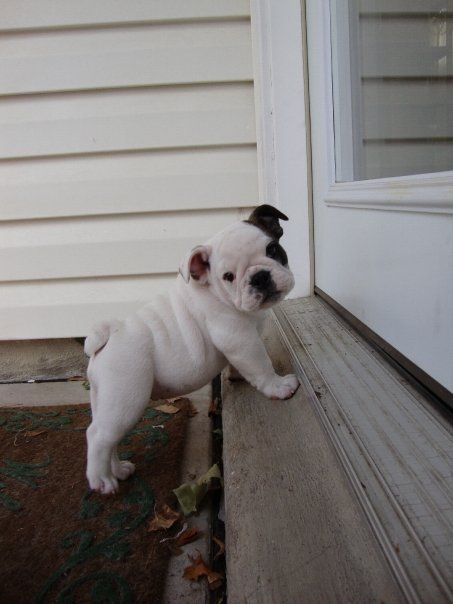

In [84]:
image = Image.open("/home/olivieri/exp/resources/puppy.jpg")
# image = Image.open("/home/olivieri/exp/resources/frappuccino.png")
print(image.size)
image

In [85]:
images_tensor = model.preprocess_images([image])
images_tensor.shape

torch.Size([1, 3, 224, 224])

In [86]:
texts_tensor = model.preprocess_texts([
    "In the image, a small white puppy with black ears and eyes is the main subject", # ground-truth caption
    "The white door behind the puppy is closed, and there's a window on the right side of the door", # ground-truth caption
    "A red ladybug is surrounded by green glass beads", # non-ground-truth caption
    "Dominating the scene is a white desk, positioned against a white brick wall" # non-ground-truth caption
    # "The background, though blurred, reveals a parking lot filled with cars.",
    # "Despite the background, the frappuccino remains the star of the image."
]).to(CONFIG['device'])

In [87]:
# with torch.no_grad(), torch.cuda.amp.autocast():
with torch.no_grad(), torch.amp.autocast(CONFIG['device']):
    flair_logits = model.get_similarity(images=images_tensor, texts=texts_tensor, broadcast=True)

flair_logits # [4.4062,  6.9531, -20.5000, -18.1719]

tensor([[ 0.2812,  0.3538, -0.0869, -0.0051]], device='cuda:0',
       dtype=torch.float16)

In [88]:
maps, min_value, max_value = model.get_maps(images_tensor, texts_tensor, map_compute_mode=map_compute_mode, upsample_size=image.size[::-1], upsample_mode=map_resize_mode, broadcast=True)
maps.shape

torch.Size([1, 4, 604, 453])

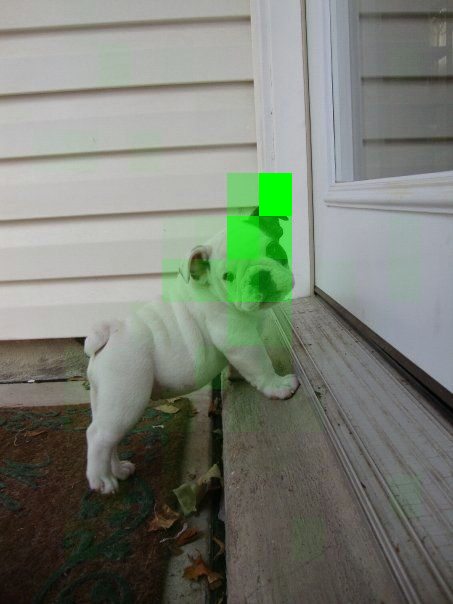

In [89]:
overlay_map(image, maps[0][0].unsqueeze(0))